In [1]:
import pandas as pd
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

In [2]:
data = sio.loadmat('./data/GAIT080624-01/gait_recording_080624_walk2.mat')
insoleAll_l = data['insoleAll_l'].astype(np.float64)
insoleAll_r = data['insoleAll_r'].astype(np.float64)
t_insole_l = data['t_insole_l'].astype(np.float64)
t_insole_r = data['t_insole_r'].astype(np.float64)

In [3]:
# Computing averages
avg_l = np.mean(insoleAll_l, axis=0)  # Result is 1 x 1024
avg_r = np.mean(insoleAll_r, axis=0)  # Result is 1 x 1024

# Reshape the averages into 64 x 16 images
img_avg_l = np.reshape(avg_l, (64, 16), order='F')
img_avg_r = np.reshape(avg_r, (64, 16), order='F')

# Flip right insole left-right and flip top half of both up-down
img_avg_r = np.fliplr(img_avg_r)
img_avg_l[:32, :] = np.flipud(img_avg_l[:32, :])
img_avg_r[:32, :] = np.flipud(img_avg_r[:32, :])

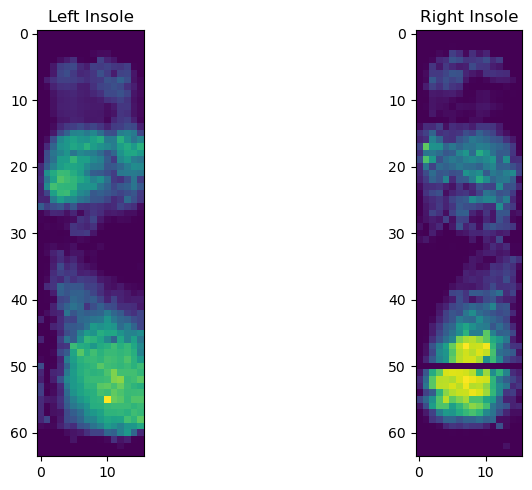

In [4]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left Insole Plot
axs[0].imshow(img_avg_l)
axs[0].set_title("Left Insole")

# Right Insole Plot
axs[1].imshow(img_avg_r)
axs[1].set_title("Right Insole")

plt.tight_layout()
plt.show()

In [5]:
# Helper function to rotate graphed line
def get_angled_line_coords(y_center, angle_deg, x_min=0, x_max=15, n_points=50):

    """
    Returns arrays of (x_vals, y_vals) in "image coordinates" for a line:
      - spanning from x_min to x_max
      - passing through (x_center, y_center) at the midpoint in x
      - tilted by angle_deg. (Positive angle = 'counterclockwise' in normal math.)
        However, note that in an imshow with origin='upper', the y-axis is inverted.
    """
    # Convert angle from degrees to radians
    angle_rad = np.deg2rad(angle_deg)

    # Generate X-values
    x_vals = np.linspace(x_min, x_max, n_points)
    
    # In a normal Cartesian system, slope = tan(angle).
    # Because imshow has the y-axis going downward (origin='upper'),
    # we'll use a negative sign so that a positive angle appears "counterclockwise" visually.
    slope = -np.tan(angle_rad)

    # We'll define the "center" in x as the midpoint
    x_center = (x_min + x_max) / 2.0

    # Equation of the line in image coords: y = y_center + slope*(x - x_center)
    y_vals = y_center + slope * (x_vals - x_center)

    return x_vals, y_vals

Left foot length: 58
Right foot length 57


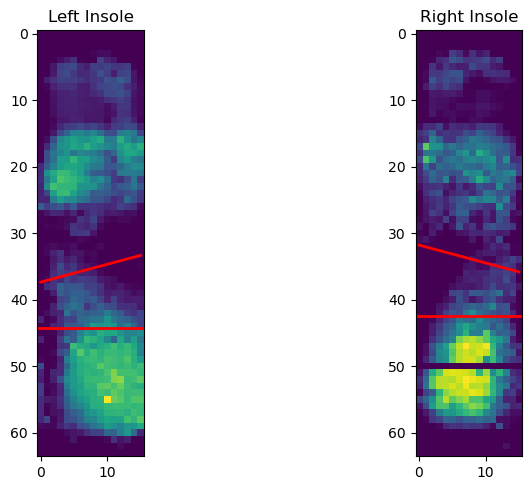

In [15]:
# Dividing foot into segments based on tarsometatarsal joint and transverse tarsal joint (54:17:29)
# Set threshold for foot to create bounding box
threshold_l = 0.1 * np.max(img_avg_l)
threshold_r = 0.1 * np.max(img_avg_r)

mask_l = img_avg_l > threshold_l
mask_r = img_avg_r > threshold_r

rows_l, cols_l = np.where(mask_l)
rows_r, cols_r = np.where(mask_r)

foot_top_l, foot_bot_l = rows_l.min(), rows_l.max()
foot_top_r, foot_bot_r = rows_r.min(), rows_r.max()

foot_length_l = foot_bot_l - foot_top_l + 1
foot_length_r = foot_bot_r - foot_top_r + 1

print("Left foot length:", foot_length_l)
print("Right foot length", foot_length_r)

# Left foot lines
line1_l = foot_top_l + 0.54 * foot_length_l         # 54% from top
line2_l = foot_bot_l - 0.29 * foot_length_l       # 29% from bottom

# Right foot lines
line1_r = foot_top_r + 0.54 * foot_length_r
line2_r = foot_bot_r - 0.29 * foot_length_r

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left Insole Plot
axs[0].imshow(img_avg_l)
axs[0].set_title("Left Insole")

# Right Insole Plot
axs[1].imshow(img_avg_r)
axs[1].set_title("Right Insole")

# Left lines
angle_left = 15 # angle of rotation
xl1, yl1 = get_angled_line_coords(line1_l, angle_left, x_min=0, x_max=15, n_points=50)
axs[0].plot(xl1, yl1, color='r', linewidth=2)
axs[0].axhline(line2_l, color='r', linewidth=2)

# Right lines
angle_right = -15 # angle of rotation
xr1, yr1 = get_angled_line_coords(line1_r, angle_right, x_min=0, x_max=15, n_points=50)
axs[1].plot(xr1, yr1, color='r', linewidth=2)
axs[1].axhline(line2_r, color='r', linewidth=2)

plt.tight_layout()
plt.show()

In [6]:
# Helper functions to divide top and bottom by ratios
def get_extreme_points_top(rows, cols, foot_top, n=15):
    """
    Extracts the (x, y) coordinates of the left‑most and right‑most points
    in the top section defined by rows [foot_top, foot_top + n).
    """
    mask_top_section = (rows >= foot_top) & (rows < foot_top + n)
    front_rows = rows[mask_top_section]
    front_cols = cols[mask_top_section]
    
    leftmost_index = np.argmin(front_cols)
    leftmost_point = (front_cols[leftmost_index], front_rows[leftmost_index])
    
    rightmost_index = np.argmax(front_cols)
    rightmost_point = (front_cols[rightmost_index], front_rows[rightmost_index])
    
    return leftmost_point, rightmost_point

def get_extreme_points_bottom(rows, cols, foot_bottom, pressure_img, n=10, min_pressure=0.5):
    """
    Extracts the (x, y) coordinates of the left‑most and right‑most points
    in the bottom section defined by rows (foot_bottom - n, foot_bottom],
    but only considers points whose pressure (from pressure_img) is at least min_pressure.
    """
    mask_bottom_section = (rows <= foot_bottom) & (rows > foot_bottom - n)
    bottom_rows = rows[mask_bottom_section]
    bottom_cols = cols[mask_bottom_section]
    
    pressure_values = pressure_img[bottom_rows, bottom_cols]
    valid_mask = pressure_values >= min_pressure
    bottom_rows = bottom_rows[valid_mask]
    bottom_cols = bottom_cols[valid_mask]
    
    if len(bottom_rows) == 0:
        return None, None
    
    leftmost_index = np.argmin(bottom_cols)
    leftmost_point = (bottom_cols[leftmost_index], bottom_rows[leftmost_index])
    
    rightmost_index = np.argmax(bottom_cols)
    rightmost_point = (bottom_cols[rightmost_index], bottom_rows[rightmost_index])
    
    return leftmost_point, rightmost_point

def divide_line(A, B, t):
    """Returns the point along the line from A to B at fraction t."""
    return (A[0] + t * (B[0] - A[0]), A[1] + t * (B[1] - A[1]))

def shrink_line(A, B, shrink_factor=0.8):
    """
    Returns new endpoints for the line segment from A to B shrunk to shrink_factor times
    its original length, while keeping the segment centered.
    """
    M = ((A[0] + B[0]) / 2.0, (A[1] + B[1]) / 2.0)
    A_shrunk = (M[0] - (shrink_factor/2.0) * (B[0] - A[0]),
                M[1] - (shrink_factor/2.0) * (B[1] - A[1]))
    B_shrunk = (M[0] + (shrink_factor/2.0) * (B[0] - A[0]),
                M[1] + (shrink_factor/2.0) * (B[1] - A[1]))
    return A_shrunk, B_shrunk

def divide_bottom_line(foot_side, bot_left, bot_right):
    """
    For the bottom of the foot, using the extreme points bot_left and bot_right,
    first shrink the line connecting them to 80% of its original length.
    Then divide that shrunken line into segments in a 3.6:7:2 ratio.
    For the left foot, the division is applied from right to left;
    for the right foot, from left to right.
    
    Returns the two divider points.
    """
    if foot_side == "left":
        A = bot_right  # rightmost bottom point
        B = bot_left   # leftmost bottom point
    elif foot_side == "right":
        A = bot_left   # leftmost bottom point
        B = bot_right  # rightmost bottom point
    else:
        raise ValueError("foot_side must be either 'left' or 'right'")
    
    A_shrunk, B_shrunk = shrink_line(A, B, shrink_factor=0.8)
    total_parts = 3.6 + 7 + 2  # 12.6 parts
    t1 = 3.6 / total_parts      # ≈0.2857
    t2 = (3.6 + 7) / total_parts  # ≈0.8413
    
    div1 = divide_line(A_shrunk, B_shrunk, t1)
    div2 = divide_line(A_shrunk, B_shrunk, t2)
    
    return div1, div2

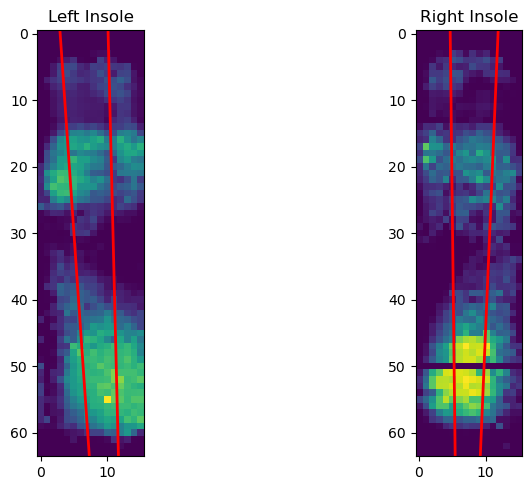

Left foot top dividers (right-to-left): (10.25, 5.5) (3.375, 6.75)
Left foot bottom dividers (from right-to-left): (11.385714285714286, 52.0) (6.496825396825397, 52.0)
Right foot top dividers (left-to-right): (4.75, 5.25) (11.625, 5.875)
Right foot bottom dividers (from left-to-right): (5.2857142857142865, 51.0) (9.730158730158731, 51.0)


In [105]:
# Segmenting based on muscles (2:5:1)
# Get extreme top points
left_top_left, left_top_right = get_extreme_points_top(rows_l, cols_l, foot_top_l, n=10)
right_top_left, right_top_right = get_extreme_points_top(rows_r, cols_r, foot_top_r, n=10)

# Get extreme bottom points (with pressure filtering; adjust min_pressure as needed)
left_bot_left, left_bot_right = get_extreme_points_bottom(rows_l, cols_l, foot_bot_l, img_avg_l, n=10, min_pressure=300)
right_bot_left, right_bot_right = get_extreme_points_bottom(rows_r, cols_r, foot_bot_r, img_avg_r, n=10, min_pressure=300)

# Divide the top line using a 2:5:1 ratio
# For the right foot (division from left to right)
right_A_top = right_top_left
right_B_top = right_top_right
right_top_div1 = divide_line(right_A_top, right_B_top, 2/8)  # left divider point
right_top_div2 = divide_line(right_A_top, right_B_top, 7/8)  # right divider point
# For the left foot (division from right to left)
left_A_top = left_top_right
left_B_top = left_top_left
left_top_div1 = divide_line(left_A_top, left_B_top, 2/8)   # right divider point
left_top_div2 = divide_line(left_A_top, left_B_top, 7/8)   # left divider point

# Divide the bottom line using a 3.6:7:2 ratio (after shrinking)
# For the right foot (division from left to right)
right_bot_div1, right_bot_div2 = divide_bottom_line("right", right_bot_left, right_bot_right)
# For the left foot (division from right to left):
left_bot_div1, left_bot_div2 = divide_bottom_line("left", left_bot_left, left_bot_right)

# Draw two lines through each foot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_avg_l)
axs[0].set_title("Left Insole")
axs[1].imshow(img_avg_r)
axs[1].set_title("Right Insole")

# Draw infinite red lines using ax.axline:
axs[0].axline(left_top_div2, left_bot_div2, color='r', linewidth=2)  # left side for left foot
axs[0].axline(left_top_div1, left_bot_div1, color='r', linewidth=2)  # right side for left foot

axs[1].axline(right_top_div1, right_bot_div1, color='r', linewidth=2)  # left side for right foot
axs[1].axline(right_top_div2, right_bot_div2, color='r', linewidth=2)  # right side for right foot

plt.tight_layout()
plt.show()

In [88]:
# Helper functions for nerve distribution
def get_point_in_row(row_idx, foot_mask, fraction=0.25):
    """
    For the given row_idx, find all columns where foot_mask[row_idx, col] == True.
    Then return (x, y) = (col, row_idx) at the specified fraction
    between the leftmost and rightmost columns.
    Example: fraction=0.25 => 1:3 ratio from leftmost to rightmost.
    """
    cols_in_row = np.where(foot_mask[row_idx, :])[0]
    if len(cols_in_row) == 0:
        return None  # No foot data in this row

    leftmost = cols_in_row.min()
    rightmost = cols_in_row.max()

    # The fraction of the way from leftmost to rightmost
    x = leftmost + fraction * (rightmost - leftmost)
    return (x, row_idx)


def get_boundary_points(foot_side, foot_mask, foot_top, foot_bot):
    """
    Returns two points:
      p1 = 1:3 ratio in the '10th row' from the top
      p2 = midpoint (1:1) in the row at 5/8 of the height from top to bottom
    Invert the fraction for the 1:3 ratio if foot_side == 'right'.
    """
    # "10th row" from top (0-based means add 9)
    row_10 = foot_top + 9

    # 5/8 down from top
    row_5_8 = int(foot_top + (5/8)*(foot_bot - foot_top))

    # For left foot => fraction=0.25 (1:3 ratio from left to right)
    # For right foot => fraction=0.75 (inverted)
    if foot_side.lower() == "left":
        frac_1_3 = 0.25
    else:
        frac_1_3 = 0.75

    p1 = get_point_in_row(row_10, foot_mask, fraction=frac_1_3)
    # p2 = midpoint => fraction=0.5
    p2 = get_point_in_row(row_5_8, foot_mask, fraction=0.5)

    return p1, p2

def draw_line_one_sided(ax, p_start, p_end, color='r'):
    """
    Parametric form:
       p(t) = p_start + t*(d),  where d = (p_end - p_start).
    We want t from 0 to tmax, so p(0)=p_start, p(1)=p_end (inside line),
    and the line extends beyond t=1 until it hits boundary, but
    does NOT go below p(0).

    bounding box: x in [0,15], y in [0,63].
    """
    if p_start is None or p_end is None:
        return
    
    x0, y0 = p_start
    x1, y1 = p_end
    dx = x1 - x0
    dy = y1 - y0
    
    # We'll find the max t such that (x0 + t*dx, y0 + t*dy) remains within [0,15]×[0,63].
    # Meanwhile, t >= 0.
    
    # If dx != 0, bounding constraints for x:
    #    0 <= x0 + t*dx <= 15
    # =>  -x0/dx <= t <= (15 - x0)/dx   if dx>0
    # or  (15 - x0)/dx <= t <= -x0/dx  if dx<0
    #
    # If dx=0, we skip x constraints.

    tmin, tmax = 0.0, float('inf')  # We'll keep t >= 0
    # handle x
    if abs(dx) > 1e-9:
        if dx > 0:
            # t in [ -x0/dx, (15 - x0)/dx ]
            left = -x0/dx
            right = (15 - x0)/dx
        else:
            # dx < 0
            left = (15 - x0)/dx
            right = -x0/dx
        # intersection with [0,∞):
        lower_bound = max(0, left)
        upper_bound = min(right, float('inf'))
        tmin = max(tmin, lower_bound)
        tmax = min(tmax, upper_bound)

    # handle y
    if abs(dy) > 1e-9:
        if dy > 0:
            # t in [ -y0/dy, (63 - y0)/dy ]
            left = -y0/dy
            right = (63 - y0)/dy
        else:
            # dy < 0
            left = (63 - y0)/dy
            right = -y0/dy
        # intersection with [0,∞)
        lower_bound = max(0, left)
        upper_bound = min(right, float('inf'))
        tmin = max(tmin, lower_bound)
        tmax = min(tmax, upper_bound)
    else:
        # dy=0 => no additional constraint on y
        pass

    if tmax < tmin:
        # no valid intersection; no line
        return
    
    # We'll draw from t=0 to t=tmax
    # p(0) = p_start, p(tmax) = p_start + tmax*d
    xA = x0 + tmin*dx
    yA = y0 + tmin*dy
    xB = x0 + tmax*dx
    yB = y0 + tmax*dy

    # Just to ensure we are inside the bounding box
    xA, yA = max(0, min(15, xA)), max(0, min(63, yA))
    xB, yB = max(0, min(15, xB)), max(0, min(63, yB))

    ax.plot([xA, xB], [yA, yB], color=color, linewidth=2)

def draw_45_deg_branches(ax, point, length=10, color='g'):
    """
    Draws two short 45° line segments ("V" shape) downward from 'point'.
    In row-column coords, "down" means increasing y.
    We'll define one branch with slope ~ +1, the other ~ -1.
    """
    x0, y0 = point

    # Left-branch: (x0 - length, y0 + length)
    x_left = x0 - length
    y_down_left = y0 + length

    # Right-branch: (x0 + length, y0 + length)
    x_right = x0 + length
    y_down_right = y0 + length

    ax.plot([x0, x_left], [y0, y_down_left], color=color, linewidth=2)
    ax.plot([x0, x_right], [y0, y_down_right], color=color, linewidth=2)

def get_45_end_right_edge(p2):
    """
    For slope = +1, param is:
       x(t) = x2 + t,   y(t) = y2 + t
    We solve for x(t)=15 => t = 15 - x2.
    Then y(t)=y2 + (15 - x2). If that exceeds 63, clamp y=63.
    Returns the intersection point (x_end, y_end).
    """
    x2, y2 = p2
    # Solve t = 15 - x2
    t = 15 - x2
    if t < 0:
        # Means p2 is already beyond the right edge or no valid intersection
        return None
    y_end = y2 + t
    # Clamp to y=63 if needed
    if y_end > 63:
        y_end = 63
    return (15, y_end)


def get_45_end_left_edge(p2):
    """
    For slope = -1, param is:
       x(t) = x2 - t,   y(t) = y2 + t
    We solve x(t)=0 => t = x2.
    Then y(t)=y2 + x2. If that exceeds 63, clamp y=63.
    Returns (0, y_end).
    """
    x2, y2 = p2
    t = x2
    if t < 0:
        # Means p2 is left of x=0 or no valid intersection
        return None
    y_end = y2 + t
    if y_end > 63:
        y_end = 63
    return (0, y_end)


def draw_curve(ax, start_pt, end_pt, shift, color='m'):
    """
    Draw a strongly curved line from start_pt to end_pt by adding
    a horizontal 'shift * t(1 - t)' term.
    - If 'shift' < 0, the curve bows left.
    - If 'shift' > 0, the curve bows right.
    """
    if (start_pt is None) or (end_pt is None):
        return
    x0, y0 = start_pt
    x1, y1 = end_pt
    
    t_vals = np.linspace(0, 1, 50)  # 50 points for smoother curve
    
    # x: linear interpolation plus a "shift * t*(1-t)" offset
    x_curve = (1 - t_vals)*x0 + t_vals*x1 + shift * t_vals*(1 - t_vals)
    # y: just linear interpolation
    y_curve = (1 - t_vals)*y0 + t_vals*y1
    
    ax.plot(x_curve, y_curve, color=color, linewidth=2)


In [60]:
# Creating mask of foot
pressure_threshold = 10

foot_mask_l = img_avg_l > pressure_threshold
foot_mask_r = img_avg_r > pressure_threshold

# Find the row/col indices of those nonzero foot mask pixels
rows_l, cols_l = np.nonzero(foot_mask_l)
rows_r, cols_r = np.nonzero(foot_mask_r)

# Find the topmost and bottommost row indices where the foot has data
foot_top_l = rows_l.min()
foot_bot_l = rows_l.max()
foot_top_r = rows_r.min()
foot_bot_r = rows_r.max()


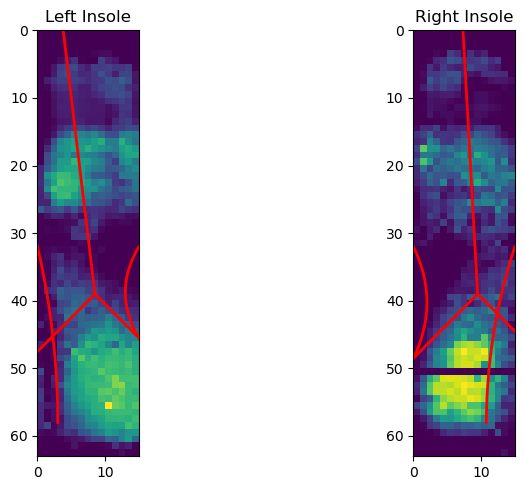

In [ ]:
# Segmenting by nerve distribution
left_p1, left_p2 = get_boundary_points("left", foot_mask_l, foot_top_l, foot_bot_l)
right_p1, right_p2 = get_boundary_points("right", foot_mask_r, foot_top_r, foot_bot_r)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Lateral and Medial Plantar nerves
# --- LEFT FOOT ---
axs[0].imshow(img_avg_l, origin='upper', cmap='viridis',
              extent=[0,16,64,0])   # so x=0..16, y=0..64 in display
axs[0].set_xlim(0,15)
axs[0].set_ylim(63,0)
axs[0].set_title("Left Insole")

# We want a line that STARTS at p2, extends in the direction (p1 - p2),
# continuing up to the boundary, but not below p2.
if left_p1 and left_p2:
    # draw the half-infinite line from p2 to bounding box in direction p1
    draw_line_one_sided(axs[0], p_start=left_p2, p_end=left_p1, color='r')
    # show the points
    axs[0].plot(left_p1[0], left_p1[1], 'r')
    axs[0].plot(left_p2[0], left_p2[1], 'r')
    # from p2, draw the 45° branches
    draw_45_deg_branches(axs[0], left_p2, color='r')

# --- RIGHT FOOT ---
axs[1].imshow(img_avg_r, origin='upper', cmap='viridis',
              extent=[0,16,64,0])
axs[1].set_xlim(0,15)
axs[1].set_ylim(63,0)
axs[1].set_title("Right Insole")

if right_p1 and right_p2:
    draw_line_one_sided(axs[1], p_start=right_p2, p_end=right_p1, color='r')
    axs[1].plot(right_p1[0], right_p1[1], 'r')
    axs[1].plot(right_p2[0], right_p2[1], 'r')
    draw_45_deg_branches(axs[1], right_p2, color='r')

# --- Define new 'effective' bottom rows, 4 up from the actual foot_bot
foot_bot_eff_l = foot_bot_l - 4
foot_bot_eff_r = foot_bot_r - 4

# Safeguard in case foot_bot_eff < foot_top, etc.
# (Optional; only if you want to clamp or skip if invalid.)
if foot_bot_eff_l < foot_top_l:
    foot_bot_eff_l = foot_top_l
if foot_bot_eff_r < foot_top_r:
    foot_bot_eff_r = foot_top_r

# Sural nerve
# --- LEFT FOOT ---
row_mid_l = (foot_top_l + foot_bot_l) // 2  # same midpoint row
x_start_l = 0                                # from the very left edge of the array
y_start_l = row_mid_l

cols_bot_eff_l = np.where(foot_mask_l[foot_bot_eff_l, :])[0]
if len(cols_bot_eff_l) > 0:
    x_left_bot_l = cols_bot_eff_l.min()
    x_right_bot_l = cols_bot_eff_l.max()
    # 1/5 from the LEFT side => fraction=0.2
    x_target_l = x_left_bot_l + 0.2 * (x_right_bot_l - x_left_bot_l)

    t_vals = np.linspace(0, 1, 30)
    # "Bow inward" by using (1 - (1-t)^2) for x progression
    x_curve_l = x_start_l + (x_target_l - x_start_l) * (1 - (1 - t_vals)**2)
    # y is a simple linear interpolation from row_mid_l down to foot_bot_eff_l
    y_curve_l = y_start_l + (foot_bot_eff_l - y_start_l) * t_vals

    axs[0].plot(x_curve_l, y_curve_l, 'r-', linewidth=2)


# --- RIGHT FOOT ---
row_mid_r = (foot_top_r + foot_bot_r) // 2
x_start_r = 15
y_start_r = row_mid_r

cols_bot_eff_r = np.where(foot_mask_r[foot_bot_eff_r, :])[0]
if len(cols_bot_eff_r) > 0:
    x_left_bot_r = cols_bot_eff_r.min()
    x_right_bot_r = cols_bot_eff_r.max()
    # "1/5 from the right" => fraction=0.8 from the left edge
    x_target_r = x_left_bot_r + 0.8 * (x_right_bot_r - x_left_bot_r)

    t_vals = np.linspace(0, 1, 30)
    x_curve_r = x_start_r + (x_target_r - x_start_r) * (1 - (1 - t_vals)**2)
    y_curve_r = y_start_r + (foot_bot_eff_r - y_start_r) * t_vals

    axs[1].plot(x_curve_r, y_curve_r, 'r-', linewidth=2)

# Saphenous nerve
# --- LEFT FOOT ---
row_mid_l = (foot_top_l + foot_bot_l) // 2
p_start_l = (15, row_mid_l)               # e.g. right edge, midpoint row
p_end_l = get_45_end_right_edge(left_p2)  # intersection with x=15 from left_p2's +45 line

# Suppose "inward" is negative shift => let's pick shift=-10 for a big bend
draw_curve(axs[0], p_start_l, p_end_l, shift=-8, color='r')

# --- RIGHT FOOT ---
row_mid_r = (foot_top_r + foot_bot_r) // 2
p_start_r = (0, row_mid_r)                # left edge, midpoint row
p_end_r = get_45_end_left_edge(right_p2)  # intersection with x=0 from right_p2's -45 line

# For the right foot, "inward" might mean shifting to larger x => shift=+10
draw_curve(axs[1], p_start_r, p_end_r, shift=8, color='r')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

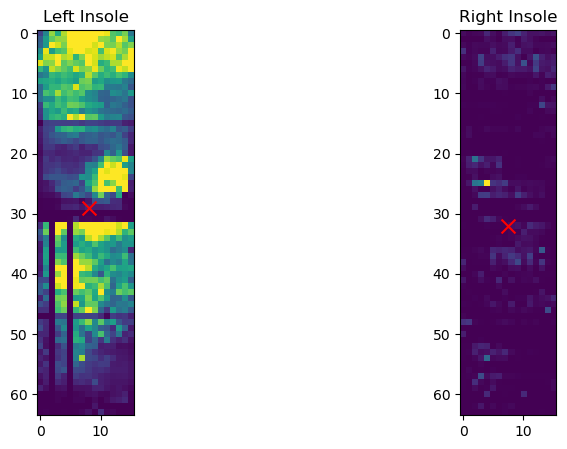

In [43]:
# Animation
# Shape (num_frames, 1024) for 64x16 heatmaps per frame
num_frames = 600  # Number of frames in data

# Set up the figure and axis for both left and right insoles
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the initial heatmap plots for both left and right insoles
img_l = axs[0].imshow(np.zeros((64, 16)), cmap='viridis')
axs[0].set_title("Left Insole")

img_r = axs[1].imshow(np.zeros((64, 16)), cmap='viridis')
axs[1].set_title("Right Insole")

# Function to update the heatmaps for each frame
def update(frame):
    # Left Insole Heatmap
    insole_l = insoleAll_l[frame]  # Get the left insole data for current frame
    img_l_data = np.reshape(insole_l, (64, 16), order='F')
    
    # Right Insole Heatmap
    insole_r = insoleAll_r[frame]  # Get the right insole data for current frame
    img_r_data = np.reshape(insole_r, (64, 16), order='F')
    img_r_data = np.fliplr(img_r_data)  # Flip the right insole image left-right

    # Update heatmap data for each subplot
    axs[0].imshow(img_l_data)
    axs[1].imshow(img_r_data)

    return [img_l, img_r, sc_l, sc_r]

# Create the animation using FuncAnimation
anim = FuncAnimation(fig, update, frames=num_frames, interval=200, blit=True)

# Display the animation
anim.save('walking_anim.mp4', writer = 'ffmpeg', fps = 60)